### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two or three people.
* The deadline is Friday, 01.06.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [1]:
%autosave 10
from scipy.special import logsumexp
import torch.distributions as distb

Autosaving every 10 seconds


In [2]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


0it [00:00, ?it/s]

Populating the interactive namespace from numpy and matplotlib


100%|█████████▉| 9895936/9912422 [00:17<00:00, 429703.00it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


32768it [00:00, 117600.16it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz



 94%|█████████▍| 1556480/1648877 [00:03<00:00, 907401.75it/s]

0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 44994.03it/s]            

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


/home/tarunk/anaconda3/envs/course/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/tarunk/anaconda3/envs/course/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [3]:
def binarize(X):
    
    # YOUR CODE HERE
    thres = 127
    return np.where(X > thres, 1.0, 0)

In [4]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

Training Data followed by binarized data


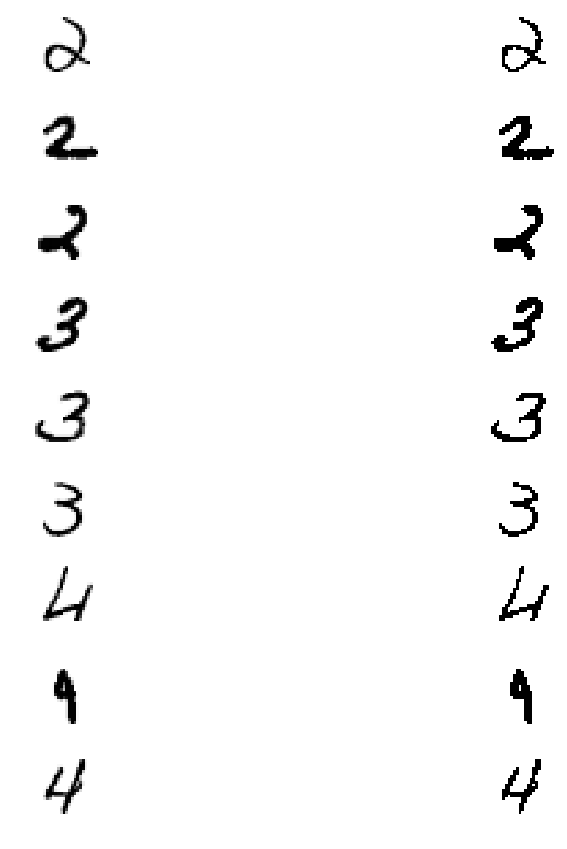

In [5]:
# YOUR CODE HERE
# randomize index
mnist_dim = (28,28)
index = np.arange(train_labels.size)
index = permutation(index)
plt.figure(figsize=(15,15))

def plot(data,num_rows,num_col,index):
    plt.subplot(num_rows,num_col,index+1)
    plt.imshow(data[0].reshape(28,28), interpolation='none', cmap='Greys')
    plt.axis('off')
    plt.subplot(num_rows,num_col,index+2)
    plt.imshow(data[1].reshape(28,28), interpolation='none', cmap='Greys')
    plt.axis('off')
    
# initial counter for 2,3,4, add new 0 for more numbers
counter = [0,0,0]
# number of images per number
number_im = 3
# number of rows & column of plot
num_rows = number_im*len(counter)
num_col = 2
for i in index:
    # check in number is 2,3 or 4 and print it
    if (train_labels[i] == 2) and counter[0] < number_im:
        plot([train_data[i],bin_train_data[i]],num_rows,num_col,counter[0]*2)
        counter[0] += 1
    elif (train_labels[i] == 3) and counter[1] < number_im:
        plot([train_data[i],bin_train_data[i]],num_rows,num_col,counter[1]*2 +number_im*2)
        counter[1] += 1
    elif (train_labels[i] == 4) and counter[2] < number_im:
        plot([train_data[i],bin_train_data[i]],num_rows,num_col,counter[2]*2 +number_im*4)
        counter[2] += 1
    
    if np.sum(counter) >= number_im*len(counter):
        print("Training Data followed by binarized data")
        plt.show()
        break
        
    

### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [6]:
def E_step(X, mu, pi):
    # YOUR CODE HERE
    
    gamma = np.log(pi)+ np.matmul(X, np.log(mu.T+1e-10)) + np.matmul((1-X), np.log((1-mu+1e-10).T))
    norm  = logsumexp(gamma, axis=1, keepdims=True)
    gamma = np.exp(gamma - norm)
    
    

    return gamma

In [7]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [8]:
def M_step(X, gamma):
    # YOUR CODE HERE
#     print(gamma.shape)
    
    N_k = gamma.sum(keepdims=True,axis=0).T
        
    mu = np.dot(X.T, gamma).T/N_k
    
    pi = np.squeeze(N_k/X.shape[0],axis=1)
    
    
   
    return mu, pi

In [9]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [10]:
def EM(X, K, max_iter, mu=None, pi=None):
    # YOUR CODE HERE
    ll = []
    stop_c = 1e-6
    
    for i in range(max_iter):
        
        if i>1 and np.abs(ll[-1]-ll[-2])< stop_c*np.abs(ll[-1]):
            print("converged after {} iterations".format(i))
            break
       
        
        # E-step
        gamma = E_step(X, mu, pi)
        
        #M-step
        mu, pi = M_step(X, gamma)
        
    
        ll.append(np.mean(mu))
   
    return mu, pi, gamma
        

def viz_reconstruction(mu, K): 
    plt.figure(figsize=(1*K,1))
    for k in range(K):
        plt.subplot(1,K,k+1)
        recons_class = np.reshape(mu[k,:], mnist_dim)
        plt.imshow(recons_class, cmap='Greys')
        plt.axis('off')
    plt.suptitle("K=%d"%K, fontsize=14)
    plt.show()  

converged after 68 iterations


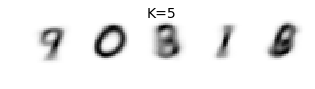

In [11]:
n_test = 10000
X = bin_train_data[:n_test]
D, K = X.shape[1], 5

np.random.seed(2018)
mu = np.random.uniform(low=.25, high=.75, size=(K,D))
norm = np.sum(mu, keepdims = True, axis=1)
mu = mu/norm
pi = np.ones(K) / K

max_iter = 200
mu, pi, gamma = EM(X ,K, max_iter, mu, pi)
viz_reconstruction(mu, K)


### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

In [12]:
classes = [2,3,4]
samples_per_class = 1000
indices = []

for class_label in classes:
    # Sample images from the given class
    indices += list(np.random.choice(np.where(train_labels == class_label)[0], samples_per_class))

data = bin_train_data[indices]
true_labels = train_labels[indices]

In [13]:

K =3
N,D = data.shape
mu = np.random.uniform(low=.25, high=.75, size=(K,D))
norm = np.sum(mu, keepdims = True, axis=1)
mu = mu/norm
pi = np.ones(K) / K

max_iter =200


converged after 29 iterations

Reconstructed digits


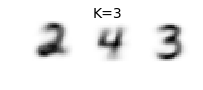


Mixing Co-efficients [0.31703361 0.352917   0.3300494 ]


In [14]:
mu, pi, gamma = EM(data, K ,  max_iter, mu, pi)
print()
print("Reconstructed digits")
viz_reconstruction(mu, K)

print()
print("Mixing Co-efficients {}".format(pi))

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

YOUR ANSWER HERE

It is easliy observable which digit belongs to which latent dimension. We observe that the mixing coefficients are very similar to the true mixing coeficients. We see that mixture of 3 Bernoulli Distributions is able to find the three clusters in the data set corresponding to the different digits. 

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

converged after 2 iterations


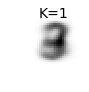

converged after 23 iterations


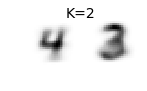

converged after 23 iterations


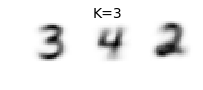

9920512it [00:30, 429703.00it/s]                             

converged after 78 iterations


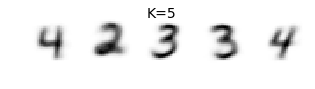

converged after 56 iterations


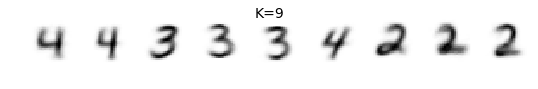

converged after 126 iterations


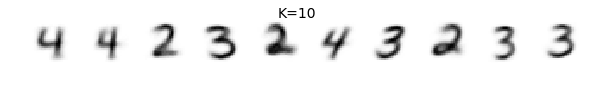

In [15]:
# YOUR CODE HERE
latent_space = [1, 2, 3, 5, 9, 10]
N, D = data.shape
max_iter =200

for K in latent_space:
    #initalizations
    #----------------------------------
    mu = np.random.uniform(low=.25, high=.75, size=(K,D))
    norm = np.sum(mu, keepdims = True, axis=1)
    mu = mu/norm
    pi = np.ones(K) / K
    #-----------------------------------
    mu, pi, gamma = EM(data, K ,  max_iter, mu, pi)
    viz_reconstruction(mu, K)
    

YOUR ANSWER HERE

Given that we have 3 true classes in our dataset (consisting of images of 2,3, and 4), we observe that for $K \gt3$ we will have duplicates in our latent class resconstructions (perhaps covering multiple modes). For values $K\lt2$, the reconstruction resemble a mix of 2, 3 and 4. As you can see for $K=1$ the reconstruciton resembles the average of three digits. For $K=3$ we get correct distribution.

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

In [16]:
np.random.seed(8)
K =3
N,D = data.shape
mu = np.random.uniform(low=.25, high=.75, size=(K,D))
norm = np.sum(mu, keepdims = True, axis=1)
mu = mu/norm
pi = np.ones(K) / K

max_iter =200


converged after 36 iterations


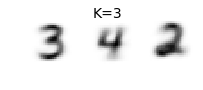

In [17]:
mu, pi, gamma = EM(data, K ,  max_iter, mu, pi)
viz_reconstruction(mu, K)

--------Misclassification-----------
Predicted Label: 2 <-------> True Label: 3


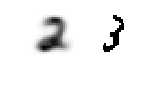

--------Misclassification-----------
Predicted Label: 4 <-------> True Label: 2


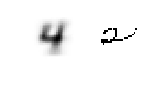

--------Misclassification-----------
Predicted Label: 2 <-------> True Label: 3


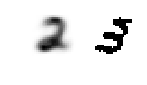

--------Misclassification-----------
Predicted Label: 3 <-------> True Label: 2


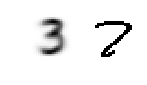

In [18]:
#We need to change the value of maping for every trained model
map_ = {0:3, 1:4, 2:2}
N, D = data.shape
for i in range(50):
    rand_img = np.random.choice(N) # randomly select image
    
    pred = np.argmax(gamma[rand_img,:])
    pred_label = map_[pred]
    true_label = true_labels[rand_img]
    
    img_true = np.reshape(data[rand_img], mnist_dim)
    img_pred = np.reshape(mu[pred], mnist_dim)
    
    if (pred_label != true_label):
        print("--------Misclassification-----------")
        plt.figure(figsize=(2,1))
        print('Predicted Label: {} <-------> True Label: {}'.format(pred_label, true_label))
        plt.subplot(1,2,1)
        plt.imshow(img_pred, cmap="Greys")
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(img_true, cmap="Greys")
        plt.axis('off')
    plt.show()
        

YOUR ANSWER HERE

To assign data label to hidden variable we can make use of gamma which is a posterior distribution i.e $\gamma(z_{nk})$ or so called responsibility. We can get argmax of probablities and can assign a label $k$ for that particular datapoint. That's what we did in above implementation. Simulataneoulsy we can find misclassified images as well, as reported. 

We observe that the misclassified images are generally either outliers (ex. poor handwriting) or very similar to another digit (ex. a '2' that is very similar to a '3'). These types of errors are not too surprising.

#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

converged after 2 iterations


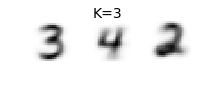


Mixing Co-efficients [0.33007837 0.35371641 0.31620521]


In [19]:
mu, pi, gamma = EM(data, K, max_iter, mu, pi)

viz_reconstruction(mu, K)

print()
print("Mixing Co-efficients {}".format(pi))

YOUR ANSWER HERE

By initializing the three classes with the true values of the parameters, we are able to converge much faster to a solution (up to the tolerance level), compared with the experiment in section 1.3. In this experiment, it only required 2 iterations to converge as compared to 35 iterations(this may vary between 25-36). This is of course expected, since we are starting the optimization with a proposed solution with a higher quality than just random.

Besides, the final mixture coefficients are close to the true mixture.

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [20]:
def log_bernoulli_loss(x_hat, x):
    loss = x*torch.log(x_hat) + (1-x)*torch.log(1-x_hat)
    loss = torch.sum(loss, dim=1)    
    
    return -torch.mean(loss)


In [21]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!

YOUR ANSWER HERE


$$\text{let }q(z) = N(z|\mu_1,\Sigma_1) \text{ and }  p(z) = N(z|\mu_2,\Sigma_2)$$
$$D_{kl}(q(z)||p(z)) = E_{q(z)}[\frac{q(z)}{p(z)}]$$
$$= \frac{1}{2}E_q(z)[-\log det\Sigma_1 - (z-\mu_1)^T\Sigma_1^{-1}(z-\mu_1) + \log det\Sigma_2 + (z -\mu_2)^T\Sigma_2^-1(z-\mu_2)]$$
$$=\frac{1}{2}\log \frac{det\Sigma_2}{det \Sigma_1} + \frac{1}{2}E_{q(z)}[-tr(\Sigma_1^{-1}(z-\mu_1)(z-\mu_1)^T) + tr(\Sigma_2^{-1}(z-\mu_1)(z-\mu_2))]$$
$$=\frac{1}{2}\log \frac{det\Sigma_2}{det \Sigma_1} + \frac{1}{2}E_{q(z)}[-tr(\Sigma_1^{-1}\Sigma_1) + tr(\Sigma_2^{-1}(zz^T - 2\mu_2\mu_1^T + \mu_2\mu_2^T))]$$
$$=\frac{1}{2}\log \frac{det\Sigma_2}{det \Sigma_1} - \frac{1}{2}n + \frac{1}{2}tr(\Sigma_2^{-1}(\Sigma_1 + \mu_1\mu_1^T - 2\mu_2\mu_1^T + \mu_2\mu_2^T))$$
$$=\frac{1}{2}(\log \frac{det\Sigma_2}{det \Sigma_1} - n + tr(\Sigma_2^{-1}\Sigma_1) + tr(\mu_1^T\Sigma_2^{-1}\Sigma_1 - 2\mu_1^T\Sigma^{-1}\mu_2 + \mu_2^T\Sigma_2^{-1}\mu_2))$$
$$=\frac{1}{2}(\log \frac{det\Sigma_2}{det \Sigma_1} - n + tr(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^T\Sigma_2^{-1}(\mu_2 - \mu_1)$$
$$\text{Replacing with actual values}$$
$$=\frac{1}{2}(\log \frac{I}{\sigma^2I} - dim + tr(I^{-1}\sigma^2I) + (0 - \mu)^T I^{-1}(0 - \mu))$$
$$=-0.5*(dim + \log {\sigma^2} - \sigma^2 - \mu^2)$$


Here we have $\mu$, $\log \sigma^2$ are vectors don't confuse with one derived in the paper. They have considered per dimension and summation over all dimension. We have used vectors and their sum.

Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [22]:
def KL_loss(mu, logvar):
    
    sigma = torch.exp(logvar)
    loss = 0.5*(1+ logvar - mu**2 - sigma)
    loss = torch.sum(loss, dim=1)
    #TODO
    #this is negative of KL so no need to multiply with -1
    
    return -torch.mean(loss)


In [23]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [24]:
def loss_function(x_hat, x, mu, logvar):
    
    # YOUR CODE HERE
    ll1 = log_bernoulli_loss(x_hat, x)
    ll2 = KL_loss(mu, logvar)
    
    return (ll1 + ll2)


In [25]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [26]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [27]:
def encode(self, x):
    h = torch.tanh(self.fc1(x))
    mu = self.fc21(h)
    logvar = self.fc22(h)
          
    return mu, logvar


In [28]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [29]:
def reparameterize(self, mu, logvar):
        sig_I = torch.diag(torch.ones(mu.size()[1]))
        mu_0  = torch.zeros(mu.size()[1])
        self.eps = distb.MultivariateNormal(mu_0, sig_I)
        
        z = mu + self.eps.sample((mu.size()[0],))* torch.sqrt(torch.exp(logvar))
        return z


In [30]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [31]:
def decode(self, z):
    h = torch.tanh(self.fc3(z))
    x_hat = torch.sigmoid(self.fc4(h))
    
    return x_hat


In [32]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [33]:
def forward(self, x):
    x = x.view(-1, 784)
    
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decode(z)
    
    return x_hat, mu, logvar


In [34]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [35]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [36]:
# Hyperparameters
fc1_dims = (784,200)
fc21_dims = (200,20)
fc22_dims = (200,20)
fc3_dims = (20,200)
fc4_dims = (200,784)
lr = 0.001
batch_size = 128
epochs = 10

# YOUR CODE HERE
# raise NotImplementedError()


In [37]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [38]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.287261
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.564635



1654784it [00:21, 907401.75it/s]                             

Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.387484
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.291710
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.233509
====> Epoch: 1 Average loss: 1.4496
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.221225
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.110613
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.079327
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.056306
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.068576
====> Epoch: 2 Average loss: 1.0896
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.050094
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.012720
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.016709
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.015127
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.975428
====> Epoch: 3 Average loss: 1.0000
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.022974
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.963418
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.946321
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.981588
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.942457
====> E

Run the box below to check if the model you trained above is able to correctly reconstruct images.

/home/tarunk/anaconda3/envs/course/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


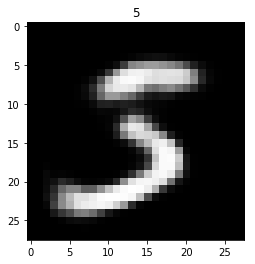

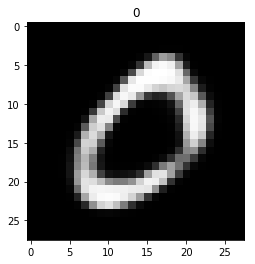

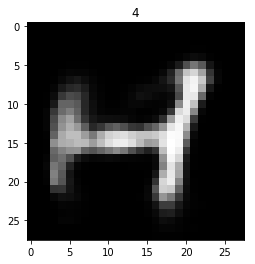

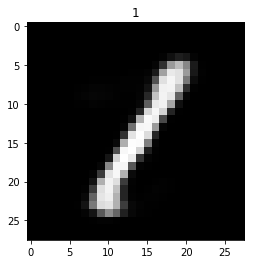

In [39]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

In [40]:
# YOUR CODE HERE
# Hyperparameters
fc1_dims = (784,200)
fc21_dims = (200,2)
fc22_dims = (200,2)
fc3_dims = (2,200)
fc4_dims = (200,784)
lr = 0.001
batch_size = 128
epochs = 10


In [41]:
# Init model
VAE_MNIST2 = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST2.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST2, optimizer)

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.304933
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.522690
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.446396
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.396554
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.433416
====> Epoch: 1 Average loss: 1.5561
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.393496
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.360901
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.412501
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.350226
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.309921
====> Epoch: 2 Average loss: 1.3810
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.352401
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.353799
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.396533
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.381534
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.304059
====> Epoch: 3 Average loss: 1.3369
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.382260
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.302000
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.287646
Train Epoch:

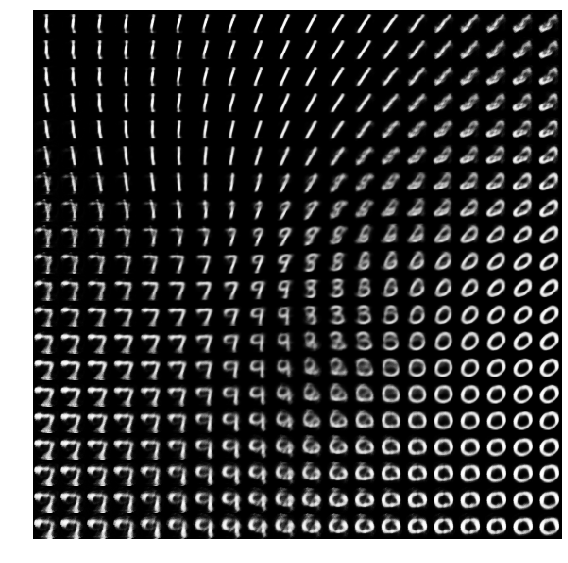

In [44]:
nx = ny = 20
x_values = np.linspace(-5, 5, nx)
y_values = np.linspace(-5, 5, ny)
canvas = np.empty((28 * ny, 28 * nx))
for ii, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        p_z = torch.FloatTensor([[xi, yi]])
        x_mean = VAE_MNIST2.decode(p_z)
        x_mean = x_mean.detach().numpy()
        canvas[(nx - ii - 1) * 28:(nx - ii) * 28, j *
                28:(j + 1) * 28] = x_mean[0].reshape(28, 28)
plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, cmap='gray')
plt.axis("off")
plt.tight_layout()

**Comments**

We can observe that the representations learned are similar to the results in Kingma 2014. Naturally, there is no reason to expect an exact match, as the learned structure of the latent space is different depending on the topology and parameters of the autoencoder.

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


YOUR ANSWER HERE

Amortized inference refers to the use of previous inference solutions (or
other pre-computation) to solve subsequent inference problems faster. There exists experimental
evidence that people leverage experience from prior inference tasks when asked to solve related
ones.This idea has inspired research into developing amortized inference systems for Bayesian
networks. These systems model $p(\textbf{x}|\textbf{z})$ by inverting the network topology and attempting to
learn the local conditional distributions of this inverted graphical model.

Amortized inference can also be achieved through variational inference. Instead of defining a
parametric family $q_{\textbf{z}}(\textbf{x}; \phi)$ which is specific to a given $\textbf{z}$, we can instead define a general family $q(\textbf{x}|\textbf{z}; \phi)$ which is conditional on $\textbf{z}$; that is, it takes $\textbf{z}$ as input. In this setting, the mean field family no longer applies, as the factors of $q$ must now be functions of $\textbf{z}$. 

This is done using the neural networks with shared parameters for the inference network as we did in part2. That is using a neural network for learning is the core amortized inference. The benfits of using amortized inference is that given a new data point, we can use the learned netowrk to obtain the approximate posterior with a fowrard pass instead of maximising the ELBO all over again.

Reference taken from https://arxiv.org/pdf/1610.05735.pdf